<img align="left" src="https://upload.wikimedia.org/wikipedia/commons/0/0c/MIT_logo.svg" width="100"></br>

<br>This notebook is adapted by Lorenzo Babini from the notebooks created by [Muthu Krishnan](https://github.com/muthuspark): A* Path Planning Line Segmentation Algorithm.ipynb</br>

Changes made by me are introduced by a ### comment

# Line and word segmentation of handwritten documents

### Convert the image to 2D grayscale.

Default first step for almost all document pre-processing is to convert it first to grayscale so we can work on a 2 Dimensional image.

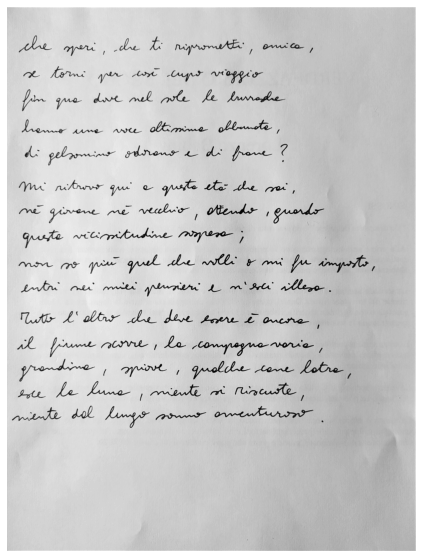

In [1]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

# read the image and check if it is based on 3 channels or 2 channels
# 3 channels means RGB or RGA; 2 channals means greyscale
# if the image is based on more then 2 channel, convert it in greyscale
img = imread("sample_data/luzi.png")
if img.ndim > 2:
    img = rgb2gray(img)

plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show()  # preview

### Find the Horizontal projection profile and find the window where line segment can be created

One of the common ways of finding the line-height of a document is by analyzing its Horizontal projection profile. Horizontal projection profile (HPP) is the array of sum or rows of a two dimentional image. Where there are more white spaces we see more peaks. These peaks give us an idea of where the segmentation between two lines can be done.

Before we run the project we should also threshold the image to clean all noise.

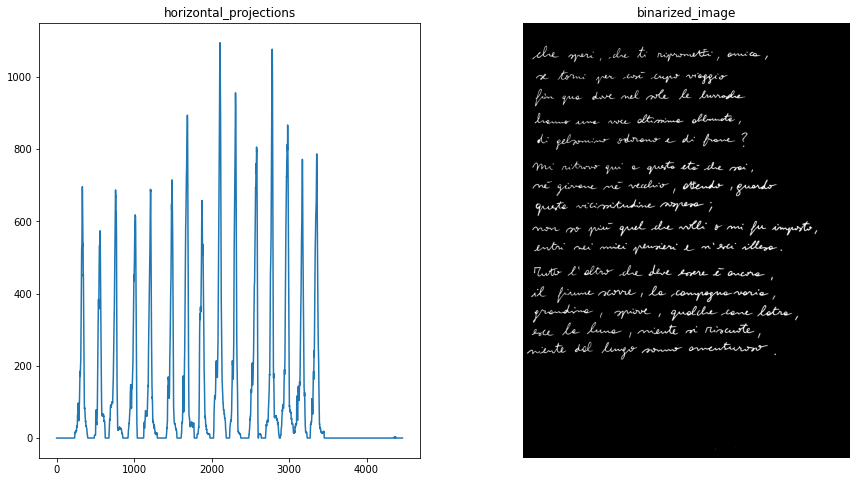

In [2]:
from skimage.filters import threshold_otsu
import numpy as np

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)  

def binarize_image(image):
    threshold = threshold_otsu(img)
    return image < threshold
    
binarized_image = binarize_image(img)
hpp = horizontal_projections(binarized_image)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.set_title("horizontal_projections")
ax1.plot(hpp)

ax2.axis("off")
ax2.set_title("binarized_image")
ax2.imshow(binarized_image, cmap="gray")

plt.show()

As you can see, where there were more white spaces there are peaks in the graph. We will use this information further to locate the regions where we can find the seperation line using the A* algorithm:


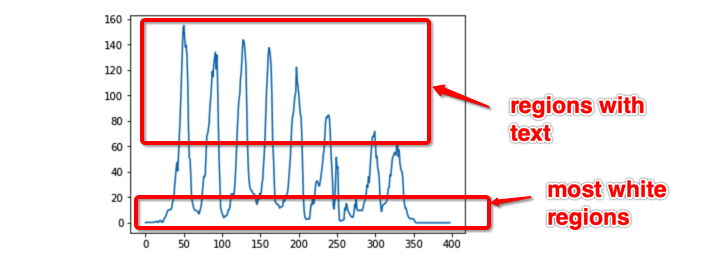


### Detect peaks in the HPP, divide the potential line segment regions from text

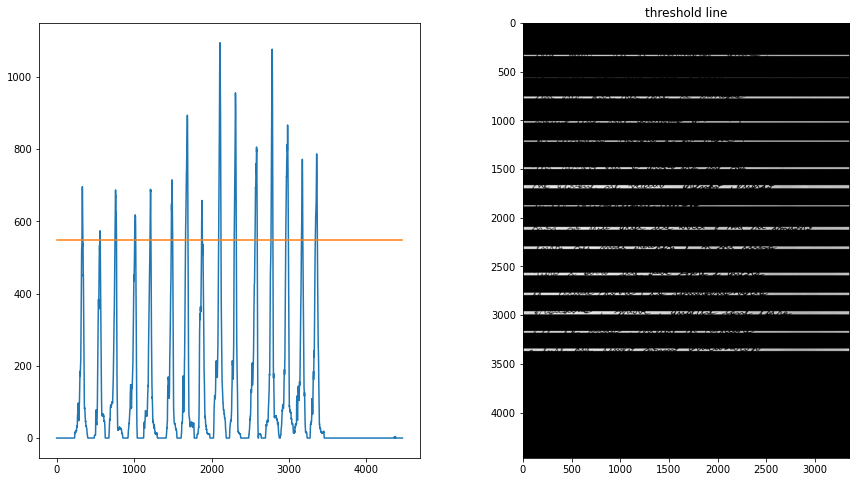

In [3]:
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):
    
    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

# find the threshold from where anything above is considered a peak region
# using the average for now but this needs further research. This may or may not work on all images.
threshold = (np.max(hpp)-np.min(hpp))/2
peaks = find_peak_regions(hpp, threshold)

peaks_indexes = np.array(peaks)[:, 0].astype(int)

segmented_img = np.copy(img)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.plot(hpp)
ax2.set_title("threshold line")
ax1.plot([0, img.shape[0]], [threshold, threshold,])
ax2.imshow(segmented_img, cmap="gray")
plt.show()

The threshold value helped us pick the probably white regions from the image. The black regions indicate where we would need to run our path planning algorithm for line segmentation.

In [4]:
# group the peaks through which we will be doing path planning.
diff_between_consec_numbers = np.diff(peaks_indexes) # difference between consecutive numbers
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
# remove very small regions, these are basically errors in algorithm because of our threshold value
peak_groups = [item for item in peak_groups if len(item) > 10]
print("peak groups found", len(peak_groups))

peak groups found 16


*WARNING : On Muth's blog, there is a way to identify the regions where upper line text is connected to the lower line and make a cut in the middle. If you need it, copy those little part of script from: https://muthu.co/segmenting-lines-in-handwritten-documents-using-a-path-planning-algorithm/*

### Run the A* path planning along the segmentation region and record the paths

A* search algorithm is a fast pathfinding algorithm to find the shortest distance between two points on a coordinate space invented by researchers working on Shakey the Robot’s path planning. Take a look at the below gif showing how it proceeds to reach the end point avoiding blocks. For more information about this algorithm, take a look on Muthu's blog or on this Youtube video: https://youtu.be/-L-WgKMFuhE


In [5]:
#a star path planning algorithm 
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))
                
    return []

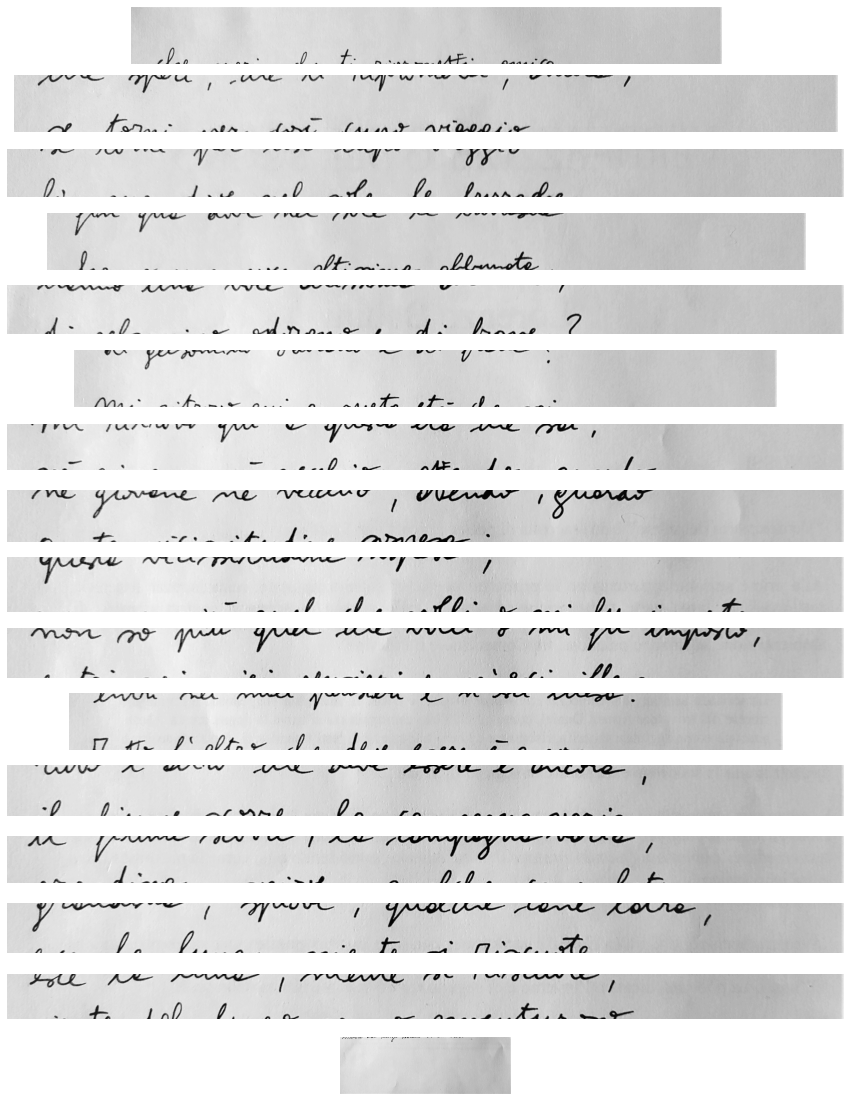

In [6]:
# Visualize the peak images
fig, ax = plt.subplots(nrows=len(peak_groups), ncols=1, figsize=(15,20))
for index, sub_image_index in enumerate(peak_groups):
    sub_image = img[sub_image_index[0]:sub_image_index[-1]]
    ax[index].axis("off")
    ax[index].imshow(sub_image, cmap="gray")
plt.show()

In [8]:
# now that everything is cleaner, its time to segment all the lines using the A* algorithm
def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary * 1
    return binary

binary_image = get_binary(img)
segment_separating_lines = []
for i, sub_image_index in enumerate(peak_groups):
    nmap = binary_image[sub_image_index[0]:sub_image_index[-1]]
    
    path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
    offset_from_top = sub_image_index[0]
    path[:,0] += offset_from_top
    segment_separating_lines.append(path)

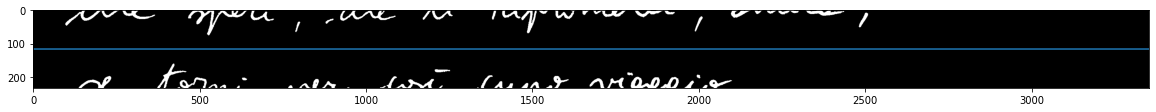

In [9]:
# visualize a sample
cluster_of_interest = peak_groups[1]
offset_from_top = cluster_of_interest[0]
nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[-1],:]
plt.figure(figsize=(20,20))
plt.imshow(nmap, cmap="gray")

path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
plt.plot(path[:,1], path[:,0])

### Plot the segmentation lines on the image

Once you have found all the paths separating the lines, you can plot them on the image or use it to extract the lines.

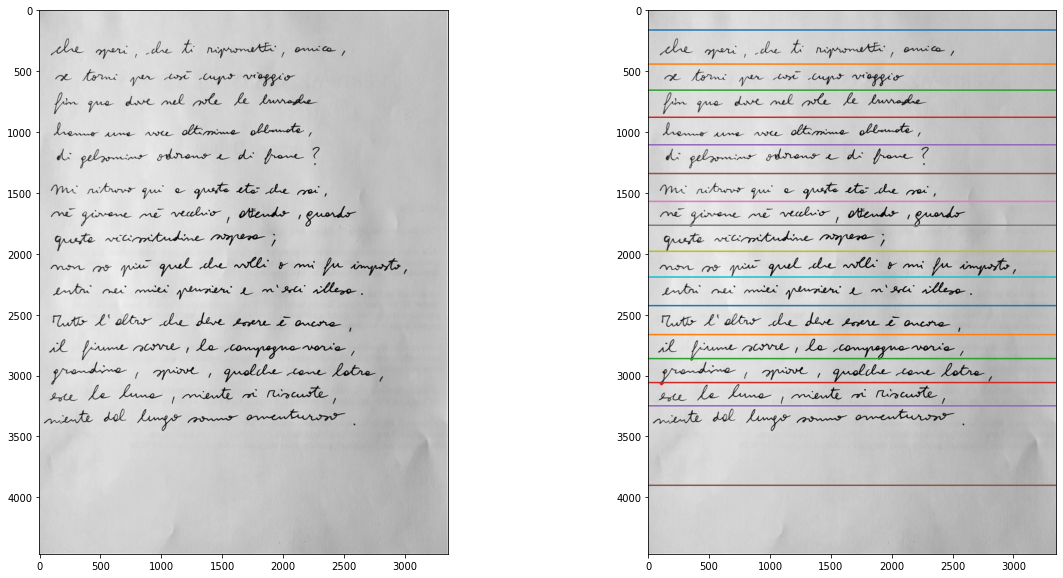

In [10]:
offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
for path in segment_separating_lines:
    ax[1].plot((path[:,1]), path[:,0])
ax[1].imshow(img, cmap="gray")
ax[0].imshow(img, cmap="gray")

### Lets divide the image now by the line segments passing through the image

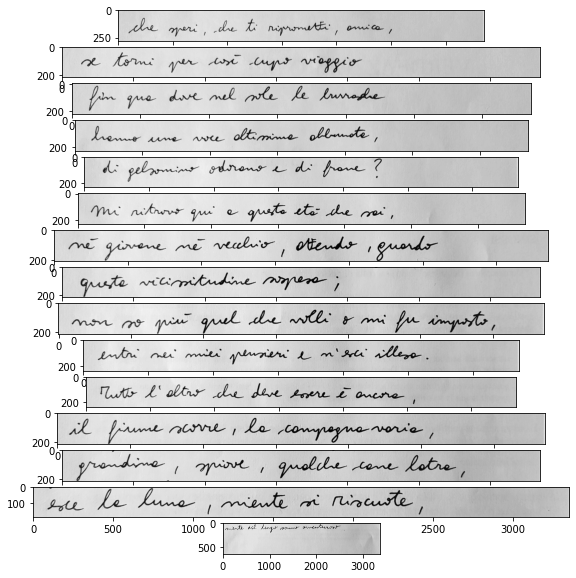

In [11]:
separated_images = []
for index, line_segments in enumerate(segment_separating_lines):
    if index < len(segment_separating_lines)-1:
        lower_line = np.min(segment_separating_lines[index][:,0])
        upper_line = np.max(segment_separating_lines[index+1][:,0])
        separated_images.append(img[lower_line:upper_line])

# visualize it
fig, ax = plt.subplots(figsize=(10,10), nrows=len(separated_images))
for index, line_image in enumerate(separated_images):
    ax[index].imshow(line_image, cmap="gray")

plt.show()

### Segmenting lines into words

Now that I have the lines, I can now divide these lines into words.

Ref: https://github.com/muthuspark/ml_research/blob/master/Separate%20words%20in%20a%20line%20using%20VPP.ipynb

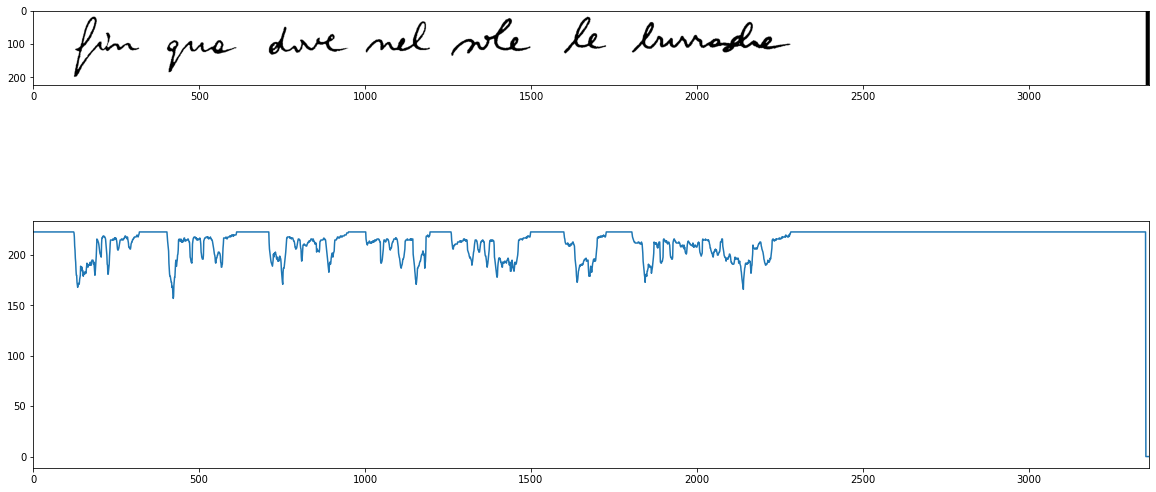

In [59]:
from skimage.filters import threshold_otsu
from PIL import Image, ImageOps

my_line = separated_images[2]

### add a black-colored right border to identify even the last white space and locate the last word
### convert the numpy array in an image with Pillow; then add a black border only on the right using ImageOps module; then reconvert the image in an array
my_line = Image.fromarray(my_line*255)
my_line_with_borders = ImageOps.expand(my_line,border=(0,0,10,0) ,fill='black')  ###https://stackoverflow.com/questions/11142851/adding-borders-to-an-image-using-python
my_line = np.asarray(my_line_with_borders)   ###https://stackoverflow.com/questions/384759/how-do-i-convert-a-pil-image-into-a-numpy-array

#binarize the image, guassian blur will remove any noise in the image
thresh = threshold_otsu(my_line)
binary = my_line > thresh

# find the vertical projection by adding up the values of all pixels along rows
vertical_projection = np.sum(binary, axis=0)

# plot the vertical projects
fig, ax = plt.subplots(nrows=2, figsize=(20,10))
plt.xlim(0, my_line.shape[1])
ax[0].imshow(binary, cmap="gray")
ax[1].plot(vertical_projection)

In [60]:
height = my_line.shape[0]

## we will go through the vertical projections and 
## find the sequence of consecutive white spaces in the image
whitespace_lengths = []
whitespace = 0
for vp in vertical_projection:
    if vp == height:
        whitespace = whitespace + 1
    elif vp != height:
        if whitespace != 0:
            whitespace_lengths.append(whitespace)
        whitespace = 0 # reset whitepsace counter. 

print("whitespaces:", whitespace_lengths)
### calculate the average lenght without consider the last white space because It could be very long and It could fake the calculation.
### this is why I considered only the slice [0:-1] in whitespace_lengths list
avg_white_space_length = np.mean(whitespace_lengths[0:-1])  
print("average whitespace lenght:", avg_white_space_length)

whitespaces: [123, 84, 98, 53, 64, 101, 78, 1070]
average whitespace lenght: 85.85714285714286


In [61]:
## find index of whitespaces which are actually long spaces using the avg_white_space_length
whitespace_length = 0
divider_indexes = []
for index, vp in enumerate(vertical_projection):
    if vp == height:
        whitespace_length = whitespace_length + 1
    elif vp != height:
        if whitespace_length != 0 and whitespace_length > (avg_white_space_length/3): ### Here I have added "/3" to "avg_white_space_length" to reduce the value of the average lenght. Here the average lenght is a tolerance limit, so lowering or increasing this value we modify the sensitivity of our segmentation. Before this adding, the white spaces shorter than the average lenghth of the white spaces was ignored.
            divider_indexes.append(index-int(whitespace_length/2))
            whitespace_length = 0 # reset it
            
print(divider_indexes)

[62, 362, 662, 977, 1228, 1550, 1766, 2818]


In [62]:
# lets create the block of words from divider_indexes
divider_indexes = np.array(divider_indexes)
dividers = np.column_stack((divider_indexes[:-1],divider_indexes[1:]))

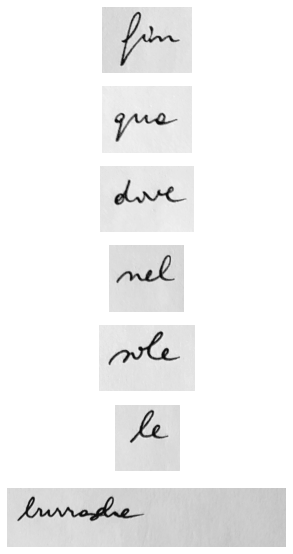

In [63]:
# now plot the findings
fig, ax = plt.subplots(nrows=len(dividers), figsize=(5,10))
for index, window in enumerate(dividers):
    ax[index].axis("off")
    ax[index].imshow(my_line[:,window[0]:window[1]], cmap="gray")